# GMM Model Training with Experimental Data

Use ```subgoal_model_030917.csv``` data from simulator to train DP-GMM model with sk-learn. Scikit-learn documentation for GMMs [here](http://scikit-learn.org/stable/modules/mixture.html).

In [35]:
%matplotlib notebook
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import pickle
import mat4py
import math
import pandas as pd

In [36]:
mpl.style.use('mitch-exp')

### Load data from 'subgoal_model_030917.csv'

Load measurements into numpy array using pandas.

In [37]:
demo_data_raw = pd.read_csv('subgoal_model_030917.csv')
demo_data_raw.head()

,Time,Boom Cmd,Stick Cmd,Bucket Cmd,Swing Cmd,Boom Ms,Stick Ms,Bucket Ms,Swing Ms
0,17.899889,7.4745,6.9645,7.614,7.4695,8.275000,3.565926,4.246154,1.267436
1,24.888776,7.4745,6.9645,7.614,7.4695,7.090032,5.085385,10.172143,1.267436
2,30.694414,7.4745,6.9645,7.614,7.4695,9.146000,5.085385,10.578111,1.267436
3,41.171175,7.4745,6.9645,7.614,7.4695,9.951429,6.469600,10.578111,-0.009817
4,46.014893,7.4745,6.9645,7.614,7.4695,9.993571,6.469600,4.593000,-0.009817


In [38]:
demo_sgs = demo_data_raw.as_matrix(columns=['Boom Ms', 'Stick Ms', 'Bucket Ms', 'Swing Ms'])

demo_sgs

array([[  8.27500000e+00,   3.56592593e+00,   4.24615385e+00,
          1.26743629e+00],
       [  7.09003226e+00,   5.08538462e+00,   1.01721429e+01,
          1.26743629e+00],
       [  9.14600000e+00,   5.08538462e+00,   1.05781111e+01,
          1.26743629e+00],
       [  9.95142857e+00,   6.46960000e+00,   1.05781111e+01,
         -9.81747704e-03],
       [  9.99357143e+00,   6.46960000e+00,   4.59300000e+00,
         -9.81747704e-03],
       [  9.95142857e+00,   4.82923077e+00,   4.54700000e+00,
          1.31946891e+00],
       [  7.52312903e+00,   4.80076923e+00,   4.54700000e+00,
          1.31946891e+00],
       [  7.55406452e+00,   8.19843750e+00,   9.44242857e+00,
          1.35481183e+00],
       [  9.82500000e+00,   8.23187500e+00,   1.02583333e+01,
          1.35481183e+00],
       [  9.86714286e+00,   8.23187500e+00,   1.02583333e+01,
         -2.35619449e-02],
       [  9.86714286e+00,   8.23187500e+00,   3.50508511e+00,
         -2.35619449e-02],
       [  8.24050000e

In [39]:
def forward_kin_v(exc, sw, bm, sk, bk, bias=0):
    '''This func is the same as 'forward_kin' in this module but is easily vectorized.

    Note: ported to Python from MATLAB "fwd_kin.m", assumed options = [0, 0]

    Args:
        exc (dict): a dict of the excavator physical parameters
        sw (float): the swing angle
        bm (float): boom displacement in cm
        sk      ^^
        bk      ^^
        bias (float): positive z bias on output, to adjust weird base frame

    Returns:
        eef (list: float): the position of the end-effector (EEF) in (x, y, z - base frame) and the angle of the bucket (axis x4 w.r.t. x1(0?) ground axis)
    '''
    # Assign the base swing angle
    t1 = sw

    # Define lengths
    a1 = exc['a1']
    a2 = exc['a2']
    a3 = exc['a3']
    a4 = exc['a4']

    # Compute or Get joint angles
    # Boom angle
    r_c1 = bm + exc['r_cyl1']
    a_a1b = np.arccos((exc['r_o1b']**2 + exc['r_o1a']**2 - r_c1**2)/(2 * exc['r_o1b']*exc['r_o1a']))
    t2 = a_a1b - exc['a_b12'] - exc['a_a1x1']

    # Stick angle
    r_c2 = sk + exc['r_cyl2']
    a_c2d = np.arccos((exc['r_o2c']**2 + exc['r_o2d']**2 - r_c2**2)/(2 * exc['r_o2c'] * exc['r_o2d']))
    t3 = 3 * np.pi - exc['a_12c'] - a_c2d - exc['a_d23']

    # Bucket angle
    r_c3 = bk + exc['r_cyl3']
    a_efh = np.arccos((exc['r_ef']**2 + exc['r_fh']**2 - r_c3**2)/(2 * exc['r_ef'] * exc['r_fh']))
    a_hf3 = np.pi - exc['a_dfe'] - a_efh
    r_o3h = math.sqrt(exc['r_o3f']**2 + exc['r_fh']**2 - 2 * exc['r_o3f'] * exc['r_fh'] * np.cos(a_hf3))
    a_f3h = np.arccos((r_o3h**2 + exc['r_o3f']**2 - exc['r_fh']**2)/(2 * r_o3h * exc['r_o3f']))
    a_h3g = np.arccos((r_o3h**2 + exc['r_o3g']**2 - exc['r_gh']**2)/(2 * r_o3h * exc['r_o3g']))
    t4 = 3 * np.pi - a_f3h - a_h3g - exc['a_g34'] - exc['a_23d']

    c1 = np.cos(t1)
    c2 = np.cos(t2)
    c234 = np.cos(t2 + t3 + t4)
    c23 = np.cos(t2 + t3)
    s1 = np.sin(t1)
    s2 = np.sin(t2)
    s234 = np.sin(t2 + t3 + t4)
    s23 = np.sin(t2 + t3)

    P04 = np.array([[c1*(a4*c234+a3*c23+a2*c2+a1)],
                    [s1*(a4*c234+a3*c23+a2*c2+a1)],
                    [(a4*s234+a3*s23+a2*s2)],
                    [1]])

    # Bucket angle; angle between x4 and x0-y0 plane
    tb = t2 + t3 + t4 - 3 * np.pi

    # Position and orientation of the end effector
    eef = [axis.pop() for axis in P04[0:3].tolist()]
    assert eef
    eef.append(tb)

    return eef[0], eef[1], eef[2] + bias

In [40]:
forward_kin = np.vectorize(forward_kin_v)
exc = mat4py.loadmat('exc.mat')['exc']

In [41]:
demo_xyz = np.array(forward_kin(exc, demo_sgs[:, 3], demo_sgs[:, 0],
                          demo_sgs[:, 1], demo_sgs[:, 2], bias=17.1))
demo_xyz.shape

(3, 72)

In [42]:
from mpl_toolkits.mplot3d import Axes3D
import itertools
from sklearn import mixture

<IPython.core.display.Javascript object>


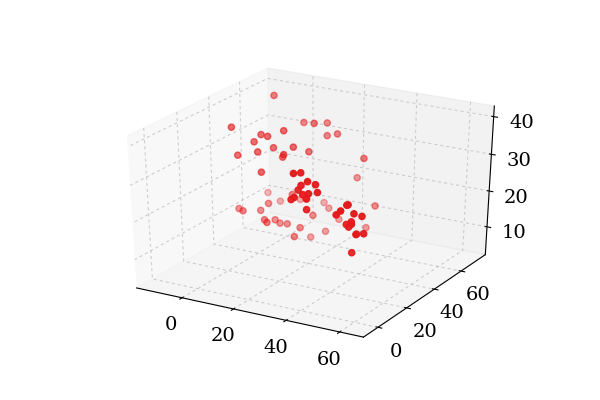

In [43]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(demo_xyz[0], demo_xyz[1], demo_xyz[2], zdir='z')

In [44]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange', 'r'])

def plot_results(X, Y_, title):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for i in range(6):
#         v, w = linalg.eigh(covar)
#         v = 2. * np.sqrt(2.) * np.sqrt(v)
#         u = w[0] / linalg.norm(w[0])
#         # as the DP will not use every component it has access to
#         # unless it needs it, we shouldn't plot the redundant
#         # components.
        if not np.any(Y_ == i):
            continue
        ax.scatter(X[Y_ == i, 0], X[Y_ == i, 1], X[Y_ == i, 2], zdir='z', c=color_iter.next())

#     plt.xlabel('X')
#     plt.ylabel('Y')
    plt.title(title)

<IPython.core.display.Javascript object>


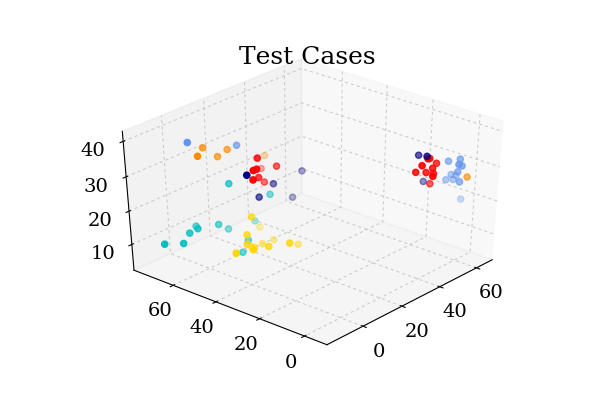

The 0'th subgoal distribution is located at [ 11.01606092   9.85061818   9.7541503    0.88530442] with covariance [[ 0.02024707 -0.02496138 -0.02364895 -0.02336631]
 [-0.02496138  1.39738321 -0.53494331  0.63515451]
 [-0.02364895 -0.53494331  0.32916243 -0.10096115]
 [-0.02336631  0.63515451 -0.10096115  0.5476925 ]].
The 1'th subgoal distribution is located at [ 7.88101882  5.42248035  3.96451377  1.39989041] with covariance [[ 0.09819667  0.14036346 -0.0595498   0.00604169]
 [ 0.14036346  1.73794123 -0.09816332  0.05399938]
 [-0.0595498  -0.09816332  0.36478522 -0.06007947]
 [ 0.00604169  0.05399938 -0.06007947  0.03710863]].
The 2'th subgoal distribution is located at [ 10.69258351   7.95905775   3.80375437   0.19891053] with covariance [[ 0.13908669  0.01881466 -0.03265481  0.08018197]
 [ 0.01881466  0.54515662 -0.2227215  -0.1884816 ]
 [-0.03265481 -0.2227215   0.3887947  -0.08776295]
 [ 0.08018197 -0.1884816  -0.08776295  0.2657388 ]].
The 3'th subgoal distribution is located at 

In [45]:
gmm = mixture.GaussianMixture(n_components=6, covariance_type='full').fit(demo_sgs)

plot_results(demo_xyz.T, gmm.predict(demo_sgs), 'Test Cases')

for i in range(6):
    print('The %i\'th subgoal distribution is located at %s with covariance %s.') % (i, gmm.means_[i], gmm.covariances_[i])

# Scale swing measurements

Try scaling the swing measurements by overhead distance between bucket and pile (58.4 cm)/(1.2 rad)

In [70]:
def orient_plot(ax):
    ax.set_xlim3d([-20, 80])
    ax.set_ylim3d([0, 80])
    ax.set_zlim3d([0, 50])
    ax.view_init(azim=-142, elev=14)

In [46]:
from sklearn import preprocessing

In [47]:
demo_sgs.shape

(72, 4)

In [72]:
# demo_normal = preprocessing.normalize(demo_sgs)
demo_normal = demo_sgs * np.array([2, 1, 1, 5])

<IPython.core.display.Javascript object>


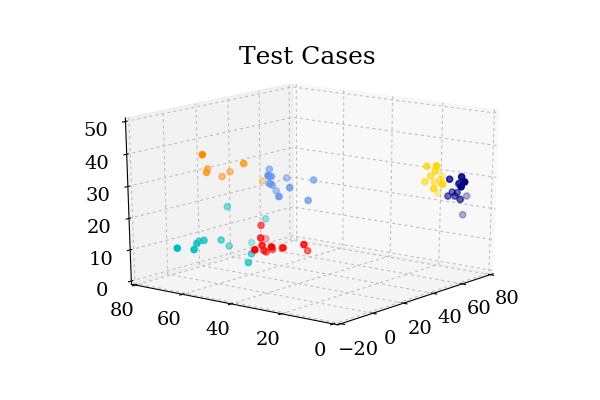

The 0'th subgoal distribution is located at [ 15.42163524   8.81113511   9.49763543   7.09916869] with covariance [[ 0.35819251  0.71139925 -0.101771    0.27293094]
 [ 0.71139925  3.0004687  -0.67164576  0.31758865]
 [-0.101771   -0.67164576  0.18385464  0.02094353]
 [ 0.27293094  0.31758865  0.02094353  0.73760103]].
The 1'th subgoal distribution is located at [  2.11770862e+01   7.99202946e+00   3.90773263e+00  -8.41498032e-03] with covariance [[ 0.58688319  0.28887844 -0.07709969 -0.01694286]
 [ 0.28887844  0.60903881 -0.38854574 -0.01547131]
 [-0.07709969 -0.38854574  0.31220209  0.02203131]
 [-0.01694286 -0.01547131  0.02203131  0.02329959]].
The 2'th subgoal distribution is located at [ 15.76203763   5.42248035   3.96451377   6.99945207] with covariance [[ 0.39278366  0.28072693 -0.11909961  0.06041686]
 [ 0.28072693  1.73794123 -0.09816332  0.26999688]
 [-0.11909961 -0.09816332  0.36478522 -0.30039736]
 [ 0.06041686  0.26999688 -0.30039736  0.92769184]].
The 3'th subgoal distrib

In [71]:
gmm_normal = mixture.GaussianMixture(n_components=6, covariance_type='full').fit(demo_normal)

plot_results(demo_xyz.T, gmm_normal.predict(demo_normal), 'Test Cases')

ax = plt.gca()
orient_plot(ax)

# for i in range(6):
#     print('The %i\'th subgoal distribution is located at %s with covariance %s.') % (i, gmm_normal.means_[i], gmm_normal.covariances_[i])

In [75]:
labels = gmm_normal.predict(demo_normal)
labels.shape

(72,)

In [80]:
def get_normal_stats_unnormalized(data, labels):
    ''' Gets the mean and covariance of clusters given the data and labels '''
    assert len(data) == len(labels)
    sg_dim = len(set(labels))
    means = np.zeros((sg_dim, 4))
    covs = np.zeros((sg_dim, 4, 4))
    for lbl in list(set(labels)):
        sg_data = data[np.where(labels == lbl)[0]]
        means[lbl] = np.mean(sg_data, axis=0)
        covs[lbl] = np.cov(sg_data.T)
    return means, covs

In [81]:
means, covs = get_normal_stats_unnormalized(demo_sgs, labels)

In [83]:
means.shape

(6, 4)

In [92]:
labels

array([2, 0, 3, 4, 1, 5, 2, 0, 3, 4, 1, 2, 0, 3, 4, 1, 2, 0, 3, 4, 1, 2, 0,
       3, 4, 1, 2, 0, 3, 4, 1, 5, 2, 0, 3, 4, 1, 5, 2, 0, 3, 4, 1, 5, 2, 0,
       3, 4, 1, 1, 5, 2, 0, 3, 4, 1, 5, 0, 3, 4, 1, 2, 0, 3, 4, 1, 5, 2, 0,
       3, 4, 1])

## Learn stochastic subgoal transition matrix $A$

Use progression of subgoals above to build empirical transition matrix. We will want more data from multiple operators later, and this (like the distributions) is a candidate for online updating.

$$
\underbrace{P(\mathbf{z}_i|z_{-i}, \mathcal{O})}_{\text{assignment posterior}} \propto \underbrace{P(\mathbf{z}_i|\mathbf{z}_{i-1})}_{transition} \underbrace{P(O_i|\mathbf{R}_i)}_{likelihood}
$$

The element $A_{bc}$ is the probability of going to subgoal $b$ from subgoal $c$.

In [95]:
pairs = np.array([(labels[i], labels[i+1]) for i in range(len(labels) - 1)])
pairs[:5]

array([[2, 0],
       [0, 3],
       [3, 4],
       [4, 1],
       [1, 5]])

In [122]:
sg_dim = len(set(labels))
permutations = np.array([[i, j] for i in range(sg_dim) for j in range(sg_dim)])

stoch_trans = np.zeros((sg_dim, sg_dim))
for p in permutations:
    a, b = p
    stoch_trans[a, b] = np.count_nonzero((pairs == p[::-1]).all(axis=1))
stoch_trans

array([[  0.,   0.,  12.,   0.,   0.,   1.],
       [  0.,   1.,   0.,   0.,  13.,   0.],
       [  0.,   5.,   0.,   0.,   0.,   6.],
       [ 13.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  13.,   0.,   0.],
       [  0.,   7.,   0.,   0.,   0.,   0.]])

In [127]:
stoch_trans_normal = stoch_trans / np.sum(stoch_trans, axis=0)
print(stoch_trans_normal)

[[ 0.          0.          1.          0.          0.          0.14285714]
 [ 0.          0.07692308  0.          0.          1.          0.        ]
 [ 0.          0.38461538  0.          0.          0.          0.85714286]
 [ 1.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.        ]
 [ 0.          0.53846154  0.          0.          0.          0.        ]]


### Build `deque`'s for rolling statistics.

In [131]:
from collections import deque

In [137]:
queues = []
for i in range(len(set(labels))):
    queues.append(deque(demo_sgs[labels == i], maxlen=5))

In [139]:
gmm_model = {'means': means,
             'covs': covs,
             'trans': stoch_trans_normal,
             'queues': queues}

with open('gmm_model_exp.pkl', 'wb') as savefile:
    pickle.dump(gmm_model, savefile)